# Time Series Analysis for Corn Future Price using ARIMA

In [1]:
# Project 3      
#importing libraries 
import pandas as pd
import numpy as np
import seaborn as sns 
import datetime as dt
import plotly.express as px
import os
import matplotlib.pyplot as plt
from pathlib import Path
%matplotlib inline
import hvplot.pandas
from pandas_datareader import data as wb
from statsmodels.tsa.arima_model import ARIMA

In [2]:
# Read in corn actual price and sort by date
corn_act_prices = pd.read_csv(Path("../Resources/corn-prices-historical-chart-data.csv"), index_col="date", infer_datetime_format=True, parse_dates=True).sort_index()
# Drop corn actual price data prior to 2000
corn_act_prices = corn_act_prices.loc['2000-1-1':]
# Rename the columns
corn_act_prices.columns.values[0] = "Corn_Price"
corn_act_prices.index.names = ['Date']
corn_act_prices.head()

,Corn_Price
Date,
2000-01-03,2.0075
2000-01-04,2.0300
2000-01-05,2.0300
2000-01-06,2.0375
2000-01-07,2.0700


In [3]:
# Drop nulls from Corn DataFrame
corn_act_prices.dropna(inplace=True)

In [4]:
# Checking Timestamp
type(corn_act_prices.index[3])

pandas._libs.tslibs.timestamps.Timestamp

In [5]:
monthly_corn_data = corn_act_prices["Corn_Price"].resample('M').mean().to_frame()
monthly_corn_data ,  monthly_corn_data.shape

(            Corn_Price
 Date                  
 2000-01-31    2.159875
 2000-02-29    2.205350
 2000-03-31    2.306848
 2000-04-30    2.283895
 2000-05-31    2.395114
 ...                ...
 2020-07-31    3.311591
 2020-08-31    3.262881
 2020-09-30    3.662738
 2020-10-31    3.988977
 2020-11-30    4.122143
 
 [251 rows x 1 columns],
 (251, 1))

In [6]:
# Check Data Types, count of each column,checking nulls and share of the DataFrame
monthly_corn_data.dtypes, monthly_corn_data.count(), monthly_corn_data.isnull().sum(), monthly_corn_data.shape

(Corn_Price    float64
 dtype: object,
 Corn_Price    251
 dtype: int64,
 Corn_Price    0
 dtype: int64,
 (251, 1))

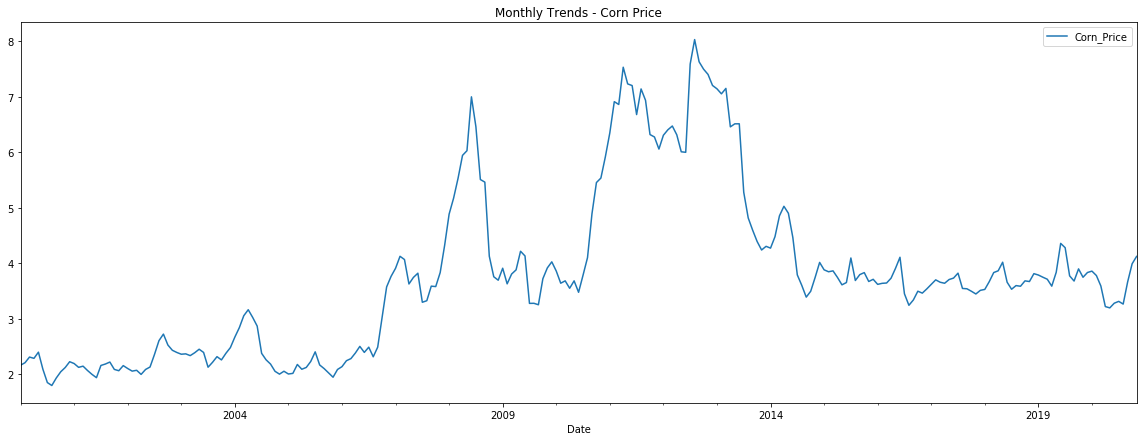

In [7]:
# Plotting and saving the Monthly Corn price trends.
monthly_corn_data.plot(title='Monthly Trends - Corn Price', figsize=(20,7))
plt.savefig("../Images/Monthly_Trends_Corn_Price.png")

## ARIMA

## Decomposition Using a Hodrick-Prescott Filter
Using a Hodrick-Prescott Filter, decompose the Corn Price into a trend, noise and seasonality.

C:\Users\Anirban\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  This is separate from the ipykernel package so we can avoid doing imports until


<Figure size 432x288 with 0 Axes>

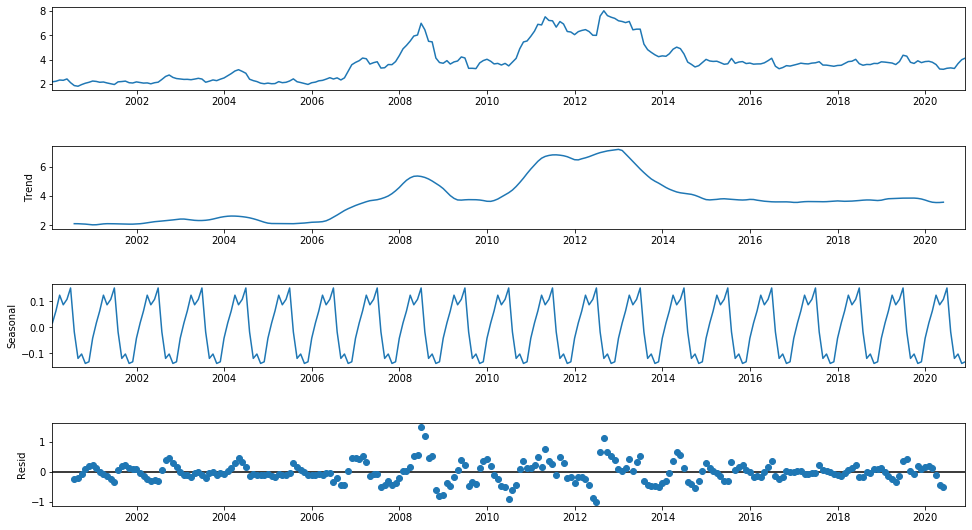

In [8]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(monthly_corn_data, freq=12)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

## Variable Selection based on Stationarity
Comparing Absolute Corn Price versus other transformed metrics to conclude which variable is better fit for model development 

In [9]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

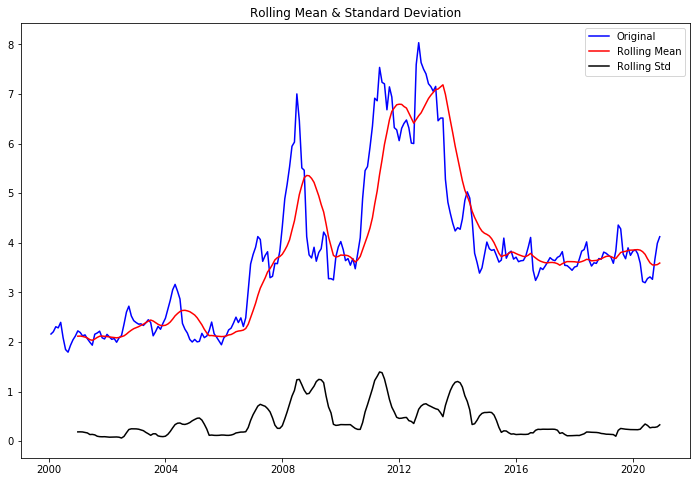

Results of Dickey-Fuller Test:
Test Statistic                  -2.040784
p-value                          0.268982
#Lags Used                      16.000000
Number of Observations Used    234.000000
Critical Value (1%)             -3.458608
Critical Value (5%)             -2.873972
Critical Value (10%)            -2.573396
dtype: float64


<Figure size 432x288 with 0 Axes>

In [10]:
# Checking Stationarity using original Corn Price, Rolling Mean and Rolling std with window of 12
test_stationarity(monthly_corn_data.Corn_Price)
plt.savefig("../Images/Stationarity_Corn.png")

C:\Users\Anirban\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


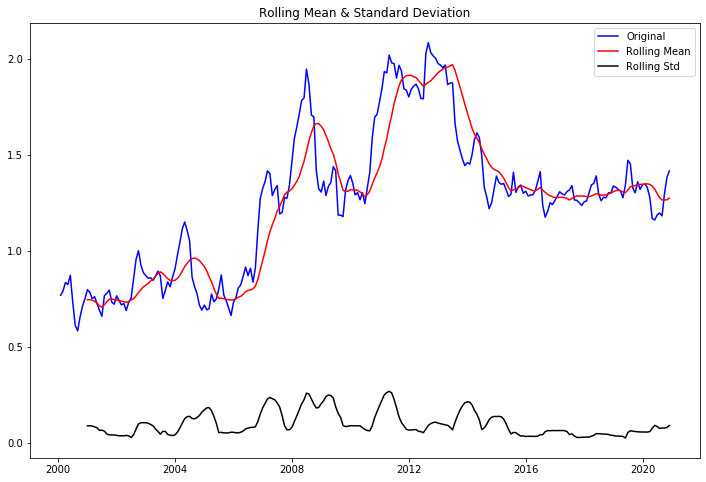

Results of Dickey-Fuller Test:
Test Statistic                  -2.079487
p-value                          0.252843
#Lags Used                       1.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


<Figure size 432x288 with 0 Axes>

In [11]:
# Checking Stationarity using original Log of Corn Price, Rolling Mean and Rolling std with window of 12
monthly_corn_data.corn_log= monthly_corn_data.Corn_Price.apply(lambda x: np.log(x))  
test_stationarity(monthly_corn_data.corn_log)
plt.savefig("../Images/Stationarity_Corn_log.png")

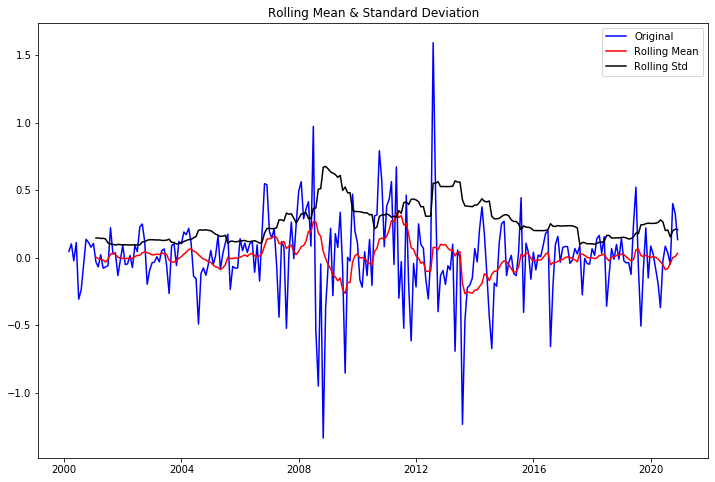

Results of Dickey-Fuller Test:
Test Statistic                  -4.172378
p-value                          0.000734
#Lags Used                      14.000000
Number of Observations Used    235.000000
Critical Value (1%)             -3.458487
Critical Value (5%)             -2.873919
Critical Value (10%)            -2.573367
dtype: float64


<Figure size 432x288 with 0 Axes>

In [12]:
# Checking Stationarity using First Difference Corn Price, Rolling Mean and Rolling std with window of 12
monthly_corn_data['first_difference'] = monthly_corn_data.Corn_Price - monthly_corn_data.Corn_Price.shift(1)  
test_stationarity(monthly_corn_data.first_difference.dropna(inplace=False))
plt.savefig("../Images/Stationarity_Corn_fd.png")

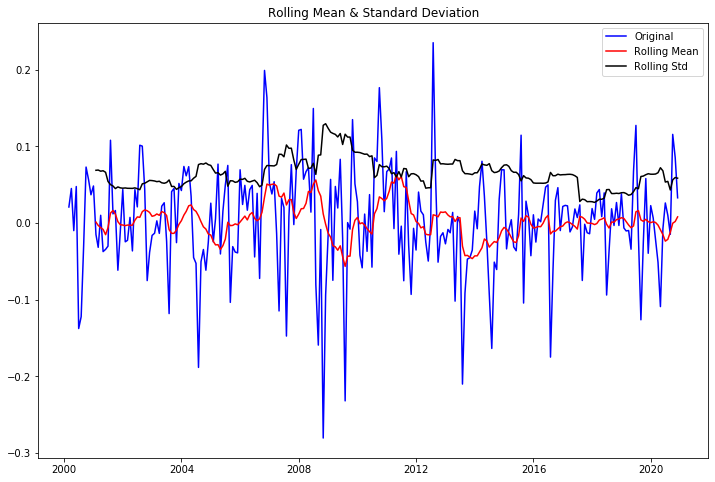

Results of Dickey-Fuller Test:
Test Statistic                -1.182199e+01
p-value                        8.372257e-22
#Lags Used                     0.000000e+00
Number of Observations Used    2.490000e+02
Critical Value (1%)           -3.456888e+00
Critical Value (5%)           -2.873219e+00
Critical Value (10%)          -2.572994e+00
dtype: float64


<Figure size 432x288 with 0 Axes>

In [13]:
# Checking Stationarity using Log of First Difference Corn Price, Rolling Mean and Rolling std with window of 12
monthly_corn_data['log_first_difference'] = monthly_corn_data.corn_log - monthly_corn_data.corn_log.shift(1)  
test_stationarity(monthly_corn_data.log_first_difference.dropna(inplace=False))
plt.savefig("../Images/Stationarity_Corn_logfd.png")

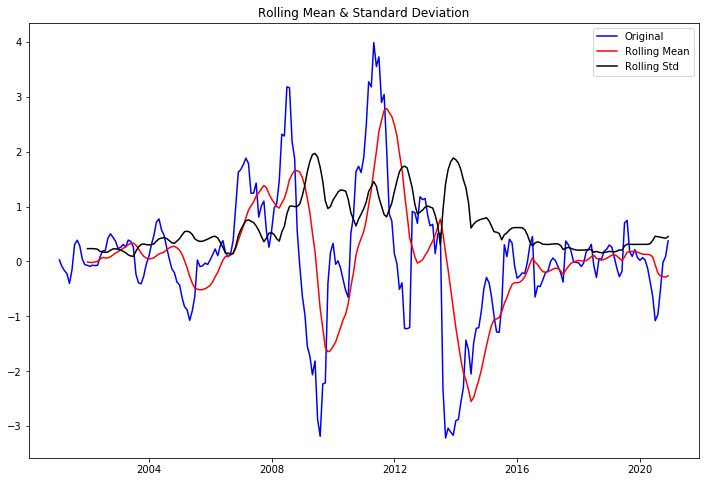

Results of Dickey-Fuller Test:
Test Statistic                  -3.084296
p-value                          0.027737
#Lags Used                      15.000000
Number of Observations Used    223.000000
Critical Value (1%)             -3.460019
Critical Value (5%)             -2.874590
Critical Value (10%)            -2.573725
dtype: float64


<Figure size 432x288 with 0 Axes>

In [14]:
# Checking Stationarity using Log of Seasonal Difference Corn Price, Rolling Mean and Rolling std with window of 12
monthly_corn_data['seasonal_diff'] = monthly_corn_data.Corn_Price - monthly_corn_data.Corn_Price.shift(12)  
test_stationarity(monthly_corn_data.seasonal_diff.dropna(inplace=False))
plt.savefig("../Images/Stationarity_Corn_sd.png")

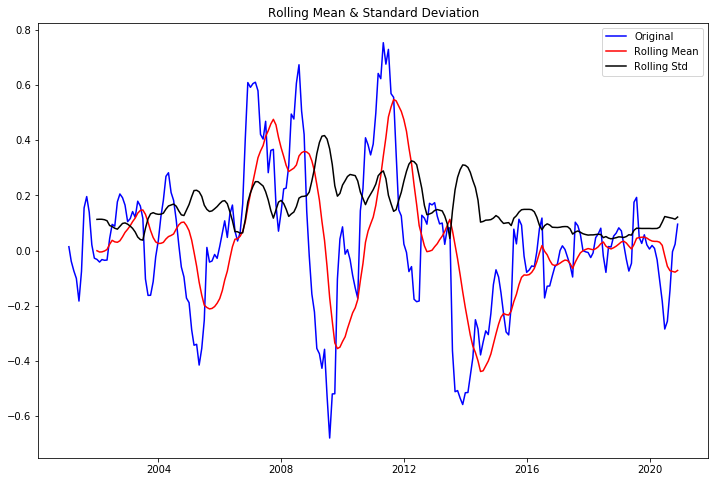

Results of Dickey-Fuller Test:
Test Statistic                  -3.097845
p-value                          0.026713
#Lags Used                      15.000000
Number of Observations Used    223.000000
Critical Value (1%)             -3.460019
Critical Value (5%)             -2.874590
Critical Value (10%)            -2.573725
dtype: float64


<Figure size 432x288 with 0 Axes>

In [15]:
# Checking Stationarity using Log of Seasonal Difference Corn Price, Rolling Mean and Rolling std with window of 12
monthly_corn_data['log_seasonal_diff'] = monthly_corn_data.corn_log - monthly_corn_data.corn_log.shift(12)
test_stationarity(monthly_corn_data.log_seasonal_diff.dropna(inplace=False))
plt.savefig("../Images/Stationarity_Corn_logsd.png")

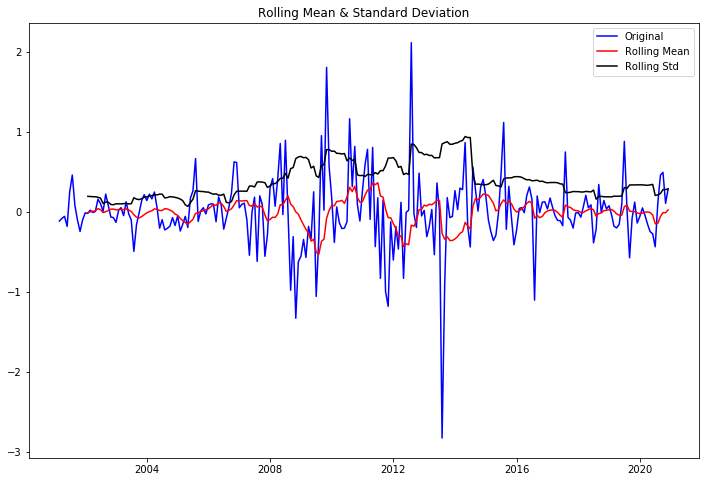

Results of Dickey-Fuller Test:
Test Statistic                -8.422186e+00
p-value                        1.969930e-13
#Lags Used                     1.100000e+01
Number of Observations Used    2.260000e+02
Critical Value (1%)           -3.459620e+00
Critical Value (5%)           -2.874415e+00
Critical Value (10%)          -2.573632e+00
dtype: float64


<Figure size 432x288 with 0 Axes>

In [16]:
# Checking Stationarity using Log of Seasonal Difference Corn Price, Rolling Mean and Rolling std with window of 12
monthly_corn_data['seasonal_first_diff'] = monthly_corn_data.first_difference - monthly_corn_data.first_difference.shift(12)
test_stationarity(monthly_corn_data.seasonal_first_diff.dropna(inplace=False))
plt.savefig("../Images/Stationarity_Corn_fd_seasonal.png")

## Running the ARIMA Model

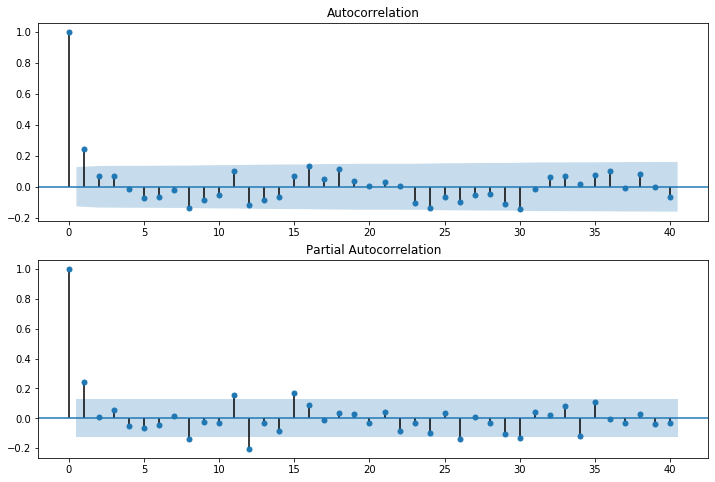

In [17]:
import statsmodels.api as sm  
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(monthly_corn_data.first_difference.iloc[13:], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(monthly_corn_data.first_difference.iloc[13:], lags=40, ax=ax2)

In [18]:
mod = sm.tsa.statespace.SARIMAX(monthly_corn_data.Corn_Price, trend='n', order=(2,1,0), seasonal_order=(0,1,1,12))
results = mod.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                           Corn_Price   No. Observations:                  251
Model:             SARIMAX(2, 1, 0)x(0, 1, [1], 12)   Log Likelihood                 -57.598
Date:                              Sat, 21 Nov 2020   AIC                            123.195
Time:                                      14:26:24   BIC                            137.084
Sample:                                  01-31-2000   HQIC                           128.793
                                       - 11-30-2020                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2345      0.065      3.599      0.000       0.107       0.362
ar.L2          0.0170      0.040      0.420      0.675      -0.062       0.096
ma.S.L12      -0.9994     11.839     -0.084      0.933     -24.204      22.206
sigma2         0.0815      0.965      0.085      0.933      -1.810       1.973
===================================================================================
Ljung-Box (Q):                       59.20   Jarque-Bera (JB):               579.05
Prob(Q):                              0.03   Prob(JB):                         0.00
Heteroskedasticity (H):               1.58   Skew:                             0.39
Prob(H) (two-sided):                  0.04   Kurtosis:                        10.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [19]:
mod = sm.tsa.statespace.SARIMAX(monthly_corn_data.Corn_Price, trend='n', order=(1,1,0), seasonal_order=(1,1,1,12))
results = mod.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                           Corn_Price   No. Observations:                  251
Model:             SARIMAX(1, 1, 0)x(1, 1, [1], 12)   Log Likelihood                 -55.118
Date:                              Sat, 21 Nov 2020   AIC                            118.237
Time:                                      14:26:26   BIC                            132.126
Sample:                                  01-31-2000   HQIC                           123.834
                                       - 11-30-2020                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2472      0.060      4.145      0.000       0.130       0.364
ar.S.L12      -0.1467      0.047     -3.134      0.002      -0.238      -0.055
ma.S.L12      -0.9979      3.925     -0.254      0.799      -8.691       6.695
sigma2         0.0788      0.308      0.256      0.798      -0.525       0.682
===================================================================================
Ljung-Box (Q):                       53.30   Jarque-Bera (JB):               508.41
Prob(Q):                              0.08   Prob(JB):                         0.00
Heteroskedasticity (H):               1.61   Skew:                             0.37
Prob(H) (two-sided):                  0.04   Kurtosis:                        10.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

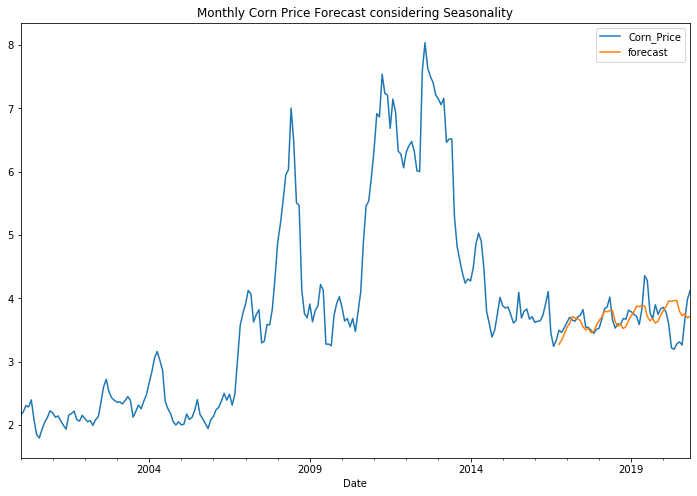

In [20]:
monthly_corn_data['forecast'] = results.predict(start = 201, end= 251, dynamic= True)  
monthly_corn_data[['Corn_Price', 'forecast']].plot(title = 'Monthly Corn Price Forecast considering Seasonality', figsize=(12, 8)) 
plt.savefig('../Images/ts_df_predict.png', bbox_inches='tight')